王振华、祁雅萍
## 静态部分
1. 文本预处理(分词、停用词等)
2. Tf-Idf将文本向量化
3. kmeans初步聚类，每一个cluster用一个TSV来表示
4. 对每个TSV摘要
    - LexRank(或者其他)获得与该TSV中心最接近的Tweet
    - 为防止获得的摘要内容过于接近，采用以下办法
    - 按公式，获得尽可能接近TSV中心、又与之前得到的推特相似度尽可能小的Tweet，其中$\lambda$是可以调节的参数
    $$
      t = argmax_{t_i} [ \lambda \frac{n_{t_i}}{n_{max}} LR(t_i) - (1-\lambda)avg_{t_j \in S}Sim(t_i, t_j)  ]
    $$
    - 往复上述步骤，获得若干条高度概括，内容有所不同的Tweet

## 动态部分
1. Pyramidal Time Frame
2. 新的Tweet进来，寻找相似度最大cluster，比较“minimum bounding similarity”，
    - 若MBS<Sim(new tweet)，则将该tweet加入该cluster；
    - 若MBS>Sim(new tweet)，则新建一个cluster；
3. 我们认为话题的时间分布是符合正态的，已知tsv可计算时间均值和方差，故可以此估计话题时间线是否已到达正态曲线的末端
4. 当cluster的数量过多时，我们需要进行合并
    
## 待解决
1. 词袋在开始时就已经确定，无法随时间变化而更新
2. 使用kmeans聚类时，没有考虑时间
    - 高永兵, 陈超, 熊振华,等. 基于个人微博特征的事件提取研究[J]. 计算机应用与软件, 2016, 33(7):47-51.
    - 先将tweet按时间分组，分别聚类，再逐渐合并
3. 只实现了静态部分，待效果达到要求后再考虑tweet stream 
4. 摘要只做到了extraction, 而不是abstraction. 需要将其进一步整合为3W1H的结构化数据
    - what : 发生了什么
    - who : 实体识别，命名体识别
    - when : 每个聚类前1%作为事件发生时间
    - how : 详细描述

## 其他
0. 当前品牌的地理分布不明显，暂时不考虑地理因素
0. 仅针对Tweet这类体裁，需要考虑url, hashtag, 发帖人之间的关系等
0. 暂时没有考虑发帖用户的比重(暂时令wi=1
0. 对命名实体加权，使结果尽量返回带有命名实体的内容(tf加权, idf不变)



In [1]:
%load_ext autoreload
%autoreload 2
import jieba
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)
from datetime import datetime 
from snownlp import normal
from matplotlib import pyplot as plt
import sklearn.cluster as skcluster
from datatype import *
from summary import *
from vectorizerIt import *
from filereader import *

In [2]:
users = readUsers('data/weibo_user.csv')
tweets = readTweets('data/user_posts.csv', noUrl=True, noTopic=True, noAtUser=True)

781
!! ['post_id', 'post_time', 'content', 'poster_id', 'poster_url', 'repost_num', 'comment_num', 'repost_post_id', 'inner_flag']
!! ['3.74487E+15', '', '', '', '', '', '', '', '']
!! ['3.66561E+15', '2014/1/11 17:26', '????????~!!!!!!!!?????????????????????~!!^^??????????????~^^', '2600208451', '', '', '', '', '']
11581


In [3]:
# 分词
corpusl_wsw = [jieba.lcut(t.content) for t in tweets]
corpusl = [normal.filter_stop(c) for c in corpusl_wsw]
corpus = [' '.join(c) for c in corpusl]

Building prefix dict from the default dictionary ...
2017-07-06 23:09:11,029 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
2017-07-06 23:09:11,035 : DEBUG : Loading model from cache /tmp/jieba.cache
Loading model cost 3.953 seconds.
2017-07-06 23:09:14,986 : DEBUG : Loading model cost 3.953 seconds.
Prefix dict has been built succesfully.
2017-07-06 23:09:14,990 : DEBUG : Prefix dict has been built succesfully.


In [4]:
otfidf = TfIdf(corpus)
# ow2v = Word2Vec(corpusl, 100)
# od2v = Doc2Vec(corpusl_wsw, 100)
vecit = otfidf

In [5]:
'''
(tvi;tsi;wi;t)
where tvi is the textual vector, 
tsi is the posted timestamp 
and wi is the UserRank value of the tweet’s author.
'''
def generateTriples(tweets, o):
    triples = []
    for i, t in enumerate(tweets):
        tvi = o.vecs[i]
        tsi = t.post_time
        wi = 1
        triples.append(TweetVector(tvi, tsi, wi, t))
    return triples
triples = generateTriples(tweets, vecit)

In [6]:
# k-means cluster
n_clusters = 10
km = skcluster.KMeans(n_clusters=n_clusters, init='random', n_init=3, verbose=0)
# km = skcluster.MeanShift()
km.fit(vecit.vecs)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=10, n_init=3, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

11581 11581


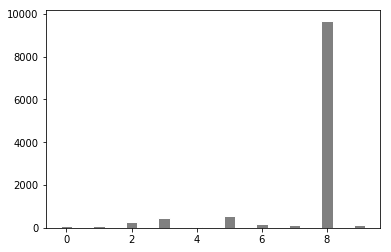

In [7]:
'''
tweet cluster vector is defined as a tuple: (sum_v; wsum_v; ts1; ts2; n; ft_set)
'''
print(len(km.labels_), len(triples))
clusters = [[] for _ in range(n_clusters)]
for i in range(len(km.labels_)):
    clusters[km.labels_[i]].append(triples[i])
# for c in clusters:
#     print(len(c))
tsvs = []
for c in clusters:
    if len(c) < 20:
        continue
    tsvs.append(TSV(c, 50))
    
plt.bar(range(len(clusters)),[len(c) for c in clusters],width = 0.35,facecolor = 'gray',edgecolor = 'white')
plt.show()

In [9]:
pp.pprint([tv.t.content for tv in tsvs[8].ft_set[:5]])

[   '???????.~^^??????????????~^^?????????~^^??',
    '???????！！！',
    '要去要去//://:',
    '心如果乱了一切都乱了',
    '??~??????????~?????????.~!?????????~??????~!???????????~^^']


In [11]:
# summary
for tsv in tsvs:
    pp.pprint(summaryLexRank(tsv, 3))
    

('哈哈哈哈哈哈笑死我了', '哈哈哈哈哈哈！谢谢你黑我', '熊孩子们！！！！！！！！哈哈哈哈哈哈')
(   '来看看我拍的MV，点此播放&gt;&gt;|美拍（通过录制）',
    '来看看我拍的MV：“”，点此播放&gt;&gt;|美拍（通过录制）',
    '来看看我拍的MV，点此播放&gt;&gt;|美拍（通过录制）')
(   '【仅剩3小时】22点，小米4最后一场放货，特别版1799元！4G红米疯抢中：红米移动4G版599元，红米Note移动4G/联通4G增强版899元！小米电视2/小米平板0首付分期购。全场配件6折起，小米手环、小米路由器mini直接买。支付金额已破14亿，有你的贡献请转发！',
    '【19点54分小米旗舰店已支付手机100万台】小米4晚八点再次开卖：特别版1799元，标准版1999元起；4G红米直降100全天放货：红米移动4G版599元，红米Note移动4G/联通4G增强版899元；小米3/小米电视2/小米平板享0元分期购，先使用再付款。热卖中，欲购从速→',
    '只要米粉想要，小米努力做到！转发为物流小伙伴鼓掌！')
('//://:转发微博', '我在追//://://:转发微博', '?这个靠谱嘛？//:转发微博')
(   '对手指干净的男生特有好感，有时甚至会因为一双手爱上一个男生。',
    '女生每个月都有那么几天特别情绪化，尽管男生永远无法体会，但男生是应该做到体谅的，当然啦亲爱的姑娘们，适当收敛下自己的小情绪和坏脾气，只有爱你的男生才会包容你的一切。',
    '男生，你凭什么不努力？')
(   '一个人至少拥有一个梦想，有一个理由去坚强。',
    '喜欢一个人，就是在一起很开心；爱一个人，就是即使不开心，也想在一起。',
    '当你喜欢某一个人的时候，会是什么样的感觉？')
(   '今晚19：30，请锁定体育频道，收看《天下足球》！',
    '【节目时间通知】今晚19:30由于直播中超榜首战国安VS恒大，本期《天下足球》临时更改为明晚（星期二）的19:30直播，请您不要错过收看。这期《天下足球》将会带来欧冠决赛特辑+绝对巨星：“蓝黑超人”萨内蒂+13/14赛季欧洲联赛50大进球，精彩不容错过！',
    '由于下周一晚19:30直播中超焦点战国安VS恒大，所以下期《天下足球

In [10]:
# summary
for tsv in tsvs:
#     weibos = [tv.t.content for tv in tsv.ft_set]
#     pp.pprint(summaryTextRank(weibos, 3))

#     pp.pprint(summaryLexRank(tsv, 3))
    pp.pprint(summaryTSVRank(tsv, 3, lbd=0.01, nmax=50))

['哈哈哈哈哈哈笑死我了', 'WiFi今天學會了睜一隻眼閉一隻眼，哈哈哈。', '哈哈哈你们这帮坏人，还让不让人好好看电视了！！！（转）']
[   '来看看我拍的MV，点此播放&gt;&gt;|美拍（通过录制）',
    '乐友孕婴童&gt;&gt;&gt;',
    '来看看我拍的MV：“玩得手气泡，玩得脚断了。”，点此播放&gt;&gt;|美拍（通过录制）']
[   '只要米粉想要，小米努力做到！转发为物流小伙伴鼓掌！',
    '【仅剩3小时】22点，小米4最后一场放货，特别版1799元！4G红米疯抢中：红米移动4G版599元，红米Note移动4G/联通4G增强版899元！小米电视2/小米平板0首付分期购。全场配件6折起，小米手环、小米路由器mini直接买。支付金额已破14亿，有你的贡献请转发！',
    '北京今天最低温度零下3℃，冬天真的来了！小伙伴那边冷吗？|小米公司']
[   '//://:转发微博',
    '新版微博客户端全新发布啦！发布器全面升级，更多兴趣快捷分享；新增微博支付，移动消费一触即达；手机端快捷参与活动，新春豪礼送不停！赶紧更新抢红包！下载地址：',
    '小伙伴们以后看电视的时候记得刷微博噢说不定还有机会在电视上看到你的微博~~']
[   '女生每个月都有那么几天特别情绪化，尽管男生永远无法体会，但男生是应该做到体谅的，当然啦亲爱的姑娘们，适当收敛下自己的小情绪和坏脾气，只有爱你的男生才会包容你的一切。',
    '对手指干净的男生特有好感，有时甚至会因为一双手爱上一个男生。',
    '男生，你凭什么不努力？']
[   '一个人至少拥有一个梦想，有一个理由去坚强。',
    '每一次不同的通话都是一个故事。',
    '很多时候，一个人发现自己爱上了一个人，都是在跟他分别的时候。突然一下子见不到那个人了，才知道自己已经不知不觉地对那个人产生了很强的依恋。']
[   '由于下周一晚19:30直播中超焦点战国安VS恒大，所以下期《天下足球》临时更改为下周二（5月27日）晚上19:30播出，请注意调整时间观看。下期节目除了带来欧冠决赛特别报道之外，还将播出《绝对巨星——萨内蒂：蓝黑超人》。这绝对将是超值的一期节目，请不要错过收看。',
    '今晚19：30，请锁定体育频道，收看《天下足球》！',


In [72]:
# def fun():
#         summaryLexRank(tsv, 3)
# %prun -s tottime fun()

<datatype.TSV object at 0x7fc0bc7f9438> 0.726403961105
0.277272604027


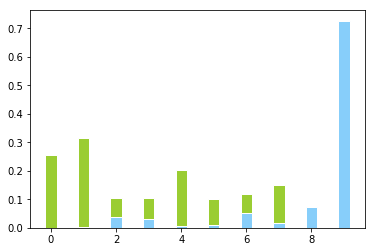

In [73]:
post = '"今天是11月9日，即“119”；明天是11月10日'
post = ' '.join(normal.filter_stop(jieba.lcut(post)))
post_vec = vecit.vectorizer(post)
# print(post_vec.data)
t = Tweet('2015/10/11 14:33', 
          post, None, None, 1, 1)
tv = TweetVector(post_vec,datetime(2015,10,11,14,33).timestamp(),1,t)

def maxSimInTSVs(tv, tsvs):
    maxSim_tsv = tsvs[0]
    maxSim = maxSim_tsv.maxSim(tv)
    sims = []
    for tsv in tsvs:
        sim = tsv.maxSim(tv)
        sims.append(sim)
        if sim > maxSim:
            maxSim_tsv = tsv
            maxSim = sim
    return maxSim_tsv, maxSim, sims

max_sim_tsv, max_sim, sims = maxSimInTSVs(tv, tsvs)
print(max_sim_tsv, max_sim)
print(max_sim_tsv.mbs(1))

plt.bar(range(len(sims)),[tsv.mbs(0.5) for tsv in tsvs],width = 0.35,facecolor = 'yellowgreen',edgecolor = 'white')
plt.bar(range(len(sims)),sims,width = 0.35,facecolor = 'lightskyblue',edgecolor = 'white')
plt.show()

In [65]:
tsvs[0].ft_set[1].tvi.nonzero()[1]

array([11627, 33855], dtype=int32)

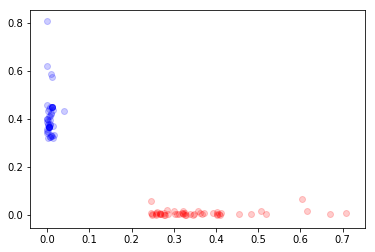

In [12]:
def cosine_similarity(v1, v2):
    if sparse.issparse(v1):
        return (sparse.csr_matrix.dot(v1, v2.transpose()) / 
                (normFor1DSparseMatrixNonZero(v1) * normFor1DSparseMatrixNonZero(v2)))[0,0]
    return (np.dot(v1, v2)) / (normFor1DSparseMatrixNonZero(v1) * normFor1DSparseMatrixNonZero(v2))
sims_8_to_8 = [cosine_similarity(tsvs[-2].cv, tv.tvi) for tv in tsvs[-2].ft_set]
sims_8_to_9 = [cosine_similarity(tsvs[-1].cv, tv.tvi) for tv in tsvs[-2].ft_set]
sims_9_to_8 = [cosine_similarity(tsvs[-2].cv, tv.tvi) for tv in tsvs[-1].ft_set]
sims_9_to_9 = [cosine_similarity(tsvs[-1].cv, tv.tvi) for tv in tsvs[-1].ft_set]
plt.scatter(sims_8_to_8,sims_8_to_9,c='red',alpha=0.2,marker='o')
plt.scatter(sims_9_to_8,sims_9_to_9,c='blue',alpha=0.2,marker='o')
plt.show()